In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.8. Wildfire Risk Spatial Analysis')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.8. Wildfire Risk Spatial Analysis/Output')
cur_date = "032223"

library(readxl)
library(tidyverse)
library(reshape2)
library(sf)
library(tigris)
library(spdep)
library(tmap)
# library(cowplot)
# library(rcartocolor)
# library(RColorBrewer)
# library(MetBrewer)

# reading in files
whp_df = data.frame(read_excel("Input/Imputed_Wildfire_Hazard_030923.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Linking to GEOS 3.11.0, GDAL 3.5.2, PROJ 9.0.1; sf_use_s2() is TRUE


Linked against: 3.11.0-CAPI-1.17.0 compiled against: 3.10.3-CAPI-1.16.1

It is probably a good idea to reinstall sf, and maybe rgeos and rgdal too

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type

In [2]:
head(whp_df)

,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%
4,14000US37141920403,37141920403,Pender,9204.0300000000007,596842.6,715.5177,5,0-20%
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%
6,14000US37141990100,37141990100,Pender,9901,596842.6,715.5177,5,0-20%


In [3]:
# download shapefile from the tigris (census package)
nc_census_tract_shapefile = tracts(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)

head(nc_census_tract_shapefile)

  |======================================================================| 100%


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,STATEFP10,COUNTYFP10,TRACTCE10,FIPS,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,37,153,970100,37153970100,9701,Census Tract 9701,G5020,S,246281647,2106825,+35.0503203,-079.6180454,153,37,MULTIPOLYGON (((-79.56729 3...
2,37,153,970200,37153970200,9702,Census Tract 9702,G5020,S,457736198,7835811,+35.0967892,-079.8225512,153,37,MULTIPOLYGON (((-79.71753 3...
3,37,153,970800,37153970800,9708,Census Tract 9708,G5020,S,139358521,2752112,+34.8508484,-079.8201950,153,37,MULTIPOLYGON (((-79.76773 3...
4,37,153,970900,37153970900,9709,Census Tract 9709,G5020,S,23311020,78240,+34.8785679,-079.7346295,153,37,MULTIPOLYGON (((-79.76773 3...
5,37,153,971000,37153971000,9710,Census Tract 9710,G5020,S,49233222,188190,+34.9395795,-079.6628977,153,37,MULTIPOLYGON (((-79.69038 3...
6,37,153,971100,37153971100,9711,Census Tract 9711,G5020,S,161136716,948938,+34.8751742,-079.6567146,153,37,MULTIPOLYGON (((-79.5684 34...


In [4]:
# first changing data type of some of the columns
whp_df$FIPS = as.character(whp_df$FIPS)

# combining data
whp_spatial_df = full_join(whp_df, nc_census_tract_shapefile)
whp_spatial_df$Wildfire_Hazard_Potential_Quintile_Number = as.character(whp_spatial_df$Wildfire_Hazard_Potential_Quintile_Number)

head(whp_spatial_df)

Joining, by = "FIPS"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9202.01,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.01,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.02,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...
4,14000US37141920403,37141920403,Pender,9204.0300000000007,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.03,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9206.01,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...
6,14000US37141990100,37141990100,Pender,9901,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9901,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...


In [5]:
# need to transform this into a sf object 
whp_spatial_sf = st_as_sf(whp_spatial_df)
head(whp_spatial_sf)

GEO_ID             FIPS        County Census_Tract       Avg_ACRES
1 14000US37141920201 37141920201 Pender 9202.01            596842.6 
2 14000US37141920401 37141920401 Pender 9204.01            596842.6 
3 14000US37141920402 37141920402 Pender 9204.02            596842.6 
4 14000US37141920403 37141920403 Pender 9204.0300000000007 596842.6 
5 14000US37141920601 37141920601 Pender 9206.01            596842.6 
6 14000US37141990100 37141990100 Pender 9901               596842.6 
  Wildfire_Hazard_Potential_Mean Wildfire_Hazard_Potential_Quintile_Number
1 715.5177                       5                                        
2 715.5177                       5                                        
3 715.5177                       5                                        
4 715.5177                       5                                        
5 715.5177                       5                                        
6 715.5177                       5                                        
  Wildfire_Hazard_Potential_Quintile_Percentage STATEFP10 COUNTYFP10
1 0-20%                                         37        141       
2 0-20%                                         37        141       
3 0-20%                                         37        141       
4 0-20%                                         37        141       
5 0-20%                                         37        141       
6 0-20%                                         37        141       
  geometry                       ⋯ NAMELSAD10           MTFCC10 FUNCSTAT10
1 MULTIPOLYGON (((-77.66061 3... ⋯ Census Tract 9202.01 G5020   S         
2 MULTIPOLYGON (((-77.94007 3... ⋯ Census Tract 9204.01 G5020   S         
3 MULTIPOLYGON (((-77.92338 3... ⋯ Census Tract 9204.02 G5020   S         
4 MULTIPOLYGON (((-77.83308 3... ⋯ Census Tract 9204.03 G5020   S         
5 MULTIPOLYGON (((-77.94027 3... ⋯ Census Tract 9206.01 G5020   S         
6 MULTIPOLYGON (((-77.67696 3... ⋯ Census Tract 9901    G5020   S         
  ALAND10   AWATER10  INTPTLAT10  INTPTLON10   COUNTYFP STATEFP
1  21147417     44942 +34.4018480 -077.6218025 141      37     
2  75755882     15209 +34.5055979 -077.9462191 141      37     
3  65209545     12064 +34.5702392 -077.9912005 141      37     
4 106488713   1076000 +34.5493899 -077.8690183 141      37     
5 103459422    348628 +34.4486577 -077.9634232 141      37     
6         0 133298842 +34.3492469 -077.6031266 141      37     
  geometry                      
1 MULTIPOLYGON (((-77.66061 3...
2 MULTIPOLYGON (((-77.94007 3...
3 MULTIPOLYGON (((-77.92338 3...
4 MULTIPOLYGON (((-77.83308 3...
5 MULTIPOLYGON (((-77.94027 3...
6 MULTIPOLYGON (((-77.67696 3...

## Finding Queen Neighbors

The `poly2nb` function builds a neighbors list based on regions with contiguous boundaries, that is sharing at least one boundary point. After it's determined which census tracts are significantly autocorrelated based on their p values, we'll come back to this and extract each census tract that was significantly autocorrelated.

In [6]:
neighbors = poly2nb(whp_spatial_sf)
neighbors

Neighbour list object:
Number of regions: 2195 
Number of nonzero links: 13612 
Percentage nonzero weights: 0.2825224 
Average number of links: 6.201367 

In [7]:
neighbors[[1]] # polygon 1 has 6 neighbors
whp_spatial_sf$GEO_ID[[1]] # geo id for this region (polygon)
whp_spatial_sf$GEO_ID[neighbors[[1]]] # geo ids for this region's neighbors

[1]  47  48  49 137 138 139

[1] "14000US37141920201"

[1] "14000US37141920102" "14000US37141920103" "14000US37141920204"
[4] "14000US37141920101" "14000US37141920202" "14000US37141920203"

## Global Moran Test

This is a test for spatial autocorrelation based off of a weights matrix. Note that the statistic falls between -1, meaning clustering of dissimilar or dispersed values (aka clustering of low to high values) and 1, meaning clustering of similar values (aka clustering of low to low or high to high values). 

In [8]:
# weight matrix
listw = nb2listw(neighbors)
listw

Characteristics of weights list object:
Neighbour list object:
Number of regions: 2195 
Number of nonzero links: 13612 
Percentage nonzero weights: 0.2825224 
Average number of links: 6.201367 

Weights style: W 
Weights constants summary:
     n      nn   S0       S1       S2
W 2195 4818025 2195 736.9648 9000.876

In [9]:
global_moran = moran.test(whp_spatial_df$Wildfire_Hazard_Potential_Mean, listw)
global_moran

# moran I statistic only
global_moran$estimate[["Moran I statistic"]]
# p value only
global_moran$p.value


	Moran I test under randomisation

data:  whp_spatial_df$Wildfire_Hazard_Potential_Mean  
weights: listw    

Moran I statistic standard deviate = 74.765, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.9220168766     -0.0004557885      0.0001522343 


[1] 0.9220169

[1] 0

Based on these results, there is strong amount of clustering of similar values (either low to low and/or high to high values) based on a statistic of ~0.92. This clustering is considered to be statistically significant (p value < 0.05). 

You may reject the null hypothesis. The spatial distribution of high values and/or low values in the dataset is more spatially clustered than would be expected if underlying spatial processes were random [ref](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm).

## Moran Plot
Visualizes the original variable on the x axis and the spatially lagged variable on the y axis fit to a linear model. The slope of the linear model is the Moran I statistic. (In our case, it's 0.92, meaning these two variables are highly correlated.) Additionally the means of each variable are plotted, since the plot is centered on these means. Therefore, the figure can be broken into 4 qudarants...
- upper-right: positive spatial correlation between high values
- lower-left: positive spatial correlation between low values
- lower-right: negative spatial correlation between high to low values
- upper-left: negative spatial correlation between low to high values

**Note:** More positive spatial correlation in upper-right and lower-left quadrants contributes to a higher Moran statistic or a slope that is closer to 1 [ref](https://geodacenter.github.io/workbook/5a_global_auto/lab5a.html#:~:text=The%20Moran%20scatter%20plot%2C%20first,in%20deviations%20from%20the%20mean). 

,x,wx,is_inf,labels,dfb.1_,dfb.x,dffit,cov.r,cook.d,hat
,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,715.5177,502.7534,TRUE,1,0.375265833,-0.553171443,-0.567753763,0.9780009,1.586719e-01,0.008984259
2,715.5177,675.6944,TRUE,2,-0.003478348,0.005127359,0.005262523,1.0099838,1.385337e-05,0.008984259
3,715.5177,579.3944,TRUE,3,0.206249550,-0.304028109,-0.312042686,1.0001612,4.847003e-02,0.008984259
4,715.5177,580.3963,TRUE,4,0.204057037,-0.300796171,-0.308725550,1.0003675,4.744989e-02,0.008984259
5,715.5177,543.9192,TRUE,5,0.284132587,-0.418833849,-0.429874854,0.9914614,9.158667e-02,0.008984259
6,715.5177,431.8320,TRUE,6,0.534949516,-0.788557789,-0.809345199,0.9465557,3.172130e-01,0.008984259


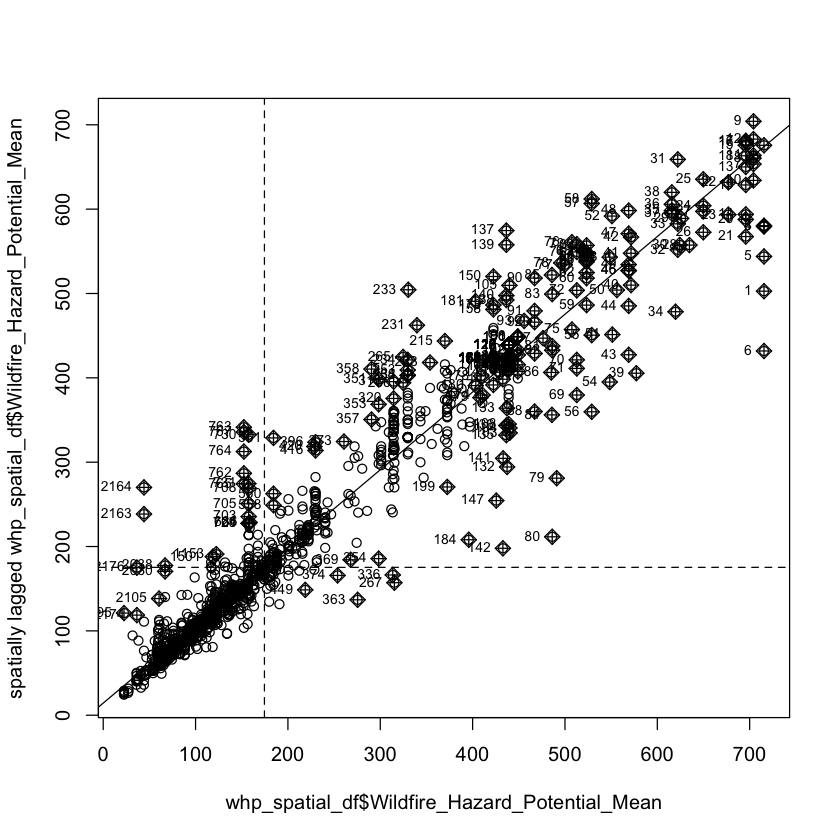

In [10]:
mp = moran.plot(whp_spatial_df$Wildfire_Hazard_Potential_Mean, listw = nb2listw(neighbors, style = "W"))
head(mp)

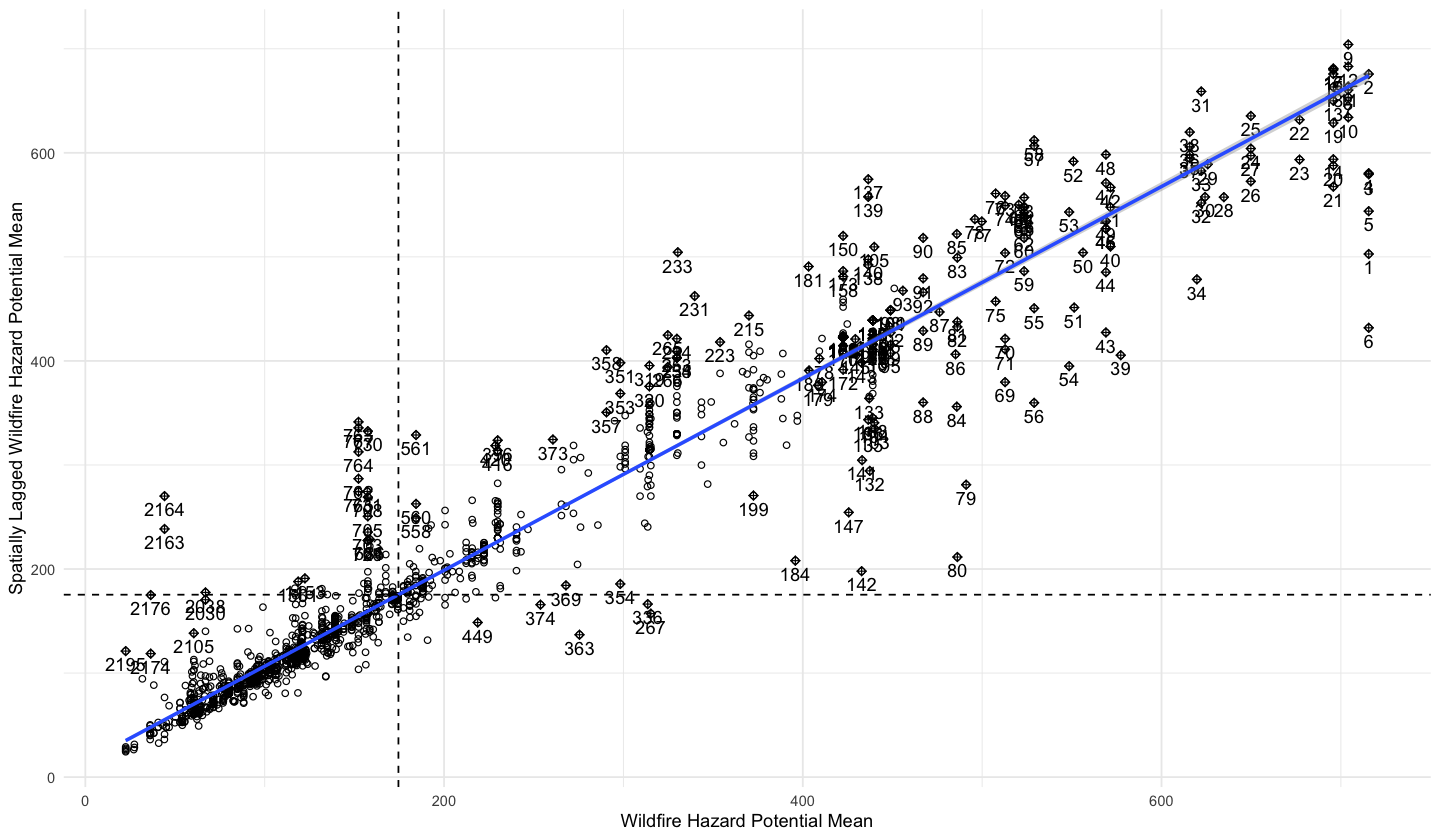

In [11]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
ggplot(mp, aes(x = x, y = wx)) + 
  geom_point(shape = 1) + 
  geom_point(data = mp[mp$is_inf,], aes(x = x, y = wx), shape = 9) +
  geom_text(data = mp[mp$is_inf,], aes(x = x, y = wx, label = labels, vjust = 1.5)) +
  geom_smooth(formula = y ~ x, method = "lm") + 
  geom_vline(xintercept = mean(mp$x), lty = 2) + # avg of whp
  geom_hline(yintercept = mean(mp$wx), lty = 2) + # avg of spatially lagged whp

  theme_minimal() + 
  xlab("Wildfire Hazard Potential Mean") + ylab("Spatially Lagged Wildfire Hazard Potential Mean")


## Local Moran

This time a moran statistic will be calculated for each geo id/ census tract to determine if that geo id has neighbors with similarily high or low values. This time a negative statistic means the region has neighbors with dissimilar values, while a positive statistic has neighbors with similar values.

The dataframe from `localmoran` has 5 columns for...
- Ii: local moran statistic

- E.Ii: expectation of local moran statistic

- Var.Ii: variance of local moran statistic

- Z.Ii: standard deviate of local moran statistic

- Pr(): p-value of local moran statistic

In [12]:
#ordered_ids = order(whp_spatial_df$GEO_ID) remove!!!
local <- data.frame(GEO_ID = whp_spatial_df$GEO_ID, # adding back in geo ids
                    localmoran(x = whp_spatial_df$Wildfire_Hazard_Potential_Mean, 
                               listw = nb2listw(neighbors, style = "W")))

# renaming col names
colnames(local)[2:6] = c("Local_Moran_Statistic", "Statistic_Expectation", "Statistic_Variance", "Statistic_Std", "P Value")

# adding a p adjusted col
local$`P Adj` = p.adjust(local$`P Value`, method = "fdr")
head(local)

,GEO_ID,Local_Moran_Statistic,Statistic_Expectation,Statistic_Variance,Statistic_Std,P Value,P Adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37141920201,11.357551,-0.008532566,3.087806,6.468236,9.915387e-11,2.901903e-09
2,14000US37141920401,17.342329,-0.008532566,4.635943,8.058459,7.726244e-16,5.717406e-14
3,14000US37141920402,14.009781,-0.008532566,4.635943,6.510686,7.480857e-11,2.218984e-09
4,14000US37141920403,14.044451,-0.008532566,3.087806,7.997303,1.271745e-15,9.004775e-14
5,14000US37141920601,12.782130,-0.008532566,3.087806,7.278938,3.364577e-13,1.420240e-11
6,14000US37141990100,8.903252,-0.008532566,3.087806,5.071538,3.946143e-07,7.467054e-06


In [13]:
# out of the 2,195 regions, 336 are significantly autocorrelated
length(local$`P Adj`[local$`P Adj` < 0.05])

[1] 336

Variable(s) "Local_Moran_Statistic" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



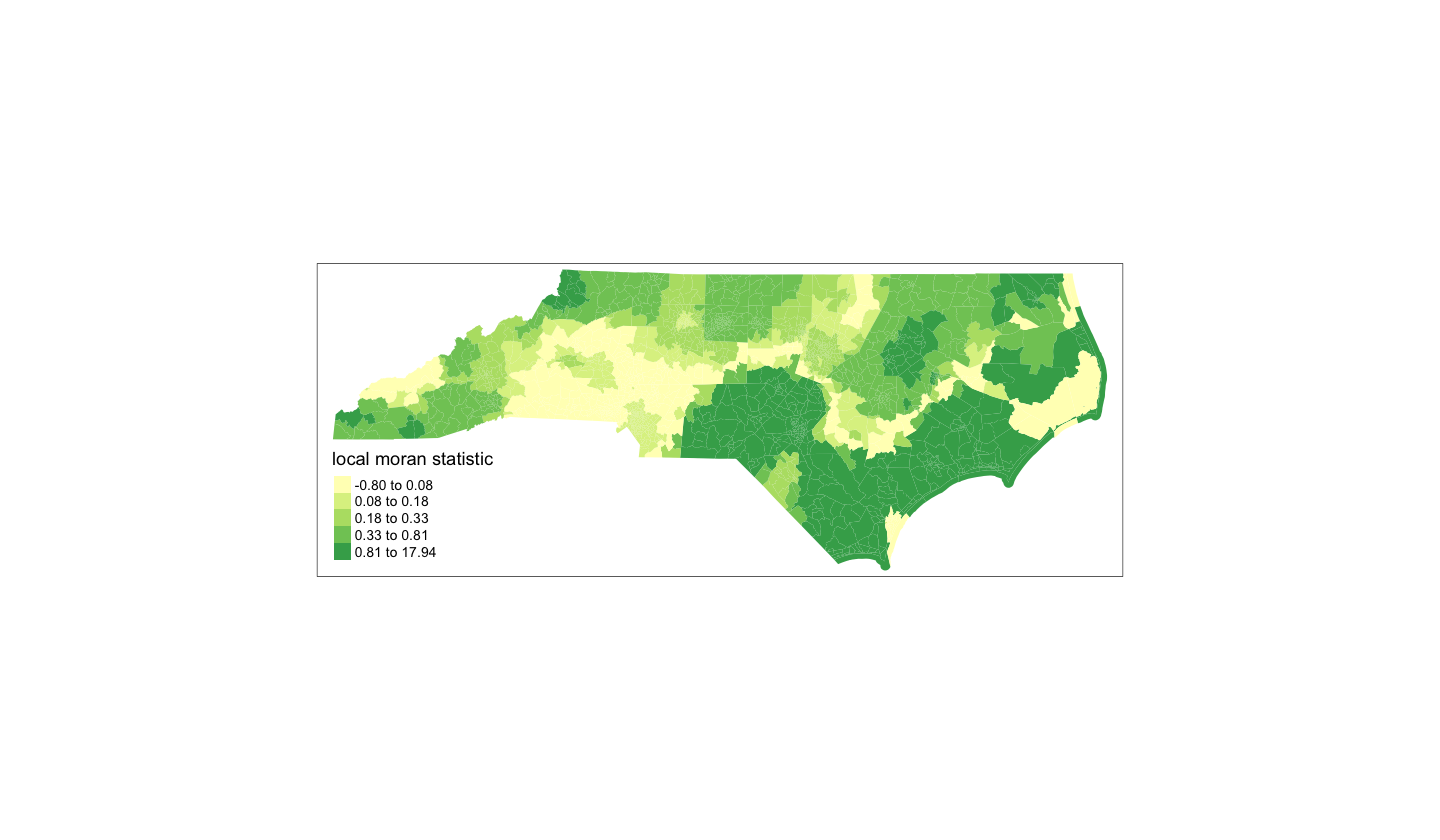

In [14]:
# plot of local moran statistics, NOT SURE IF WE REALLY NEED THIS
moran.map <- cbind(whp_spatial_sf, local)
tm_shape(moran.map) +
  tm_fill(col = "Local_Moran_Statistic",
          style = "quantile",
          title = "local moran statistic") 

In [15]:
# plotting LISA clusters...whatever that means
quadrant <- vector(mode = "numeric",length = nrow(local))

# centers the variable of interest around its mean
m.qualification <- whp_spatial_df$Wildfire_Hazard_Potential_Mean - mean(whp_spatial_df$Wildfire_Hazard_Potential_Mean)     

# centers the local Moran's around the mean
m.local <- local$Local_Moran_Statistic - mean(local$Local_Moran_Statistic)    

# significance threshold
signif <- 0.05 

# builds a data quadrant
quadrant[m.qualification > 0 & m.local > 0] <- 4  
quadrant[m.qualification < 0 & m.local < 0] <- 1      
quadrant[m.qualification < 0 & m.local > 0] <- 2
quadrant[m.qualification > 0 & m.local < 0] <- 3
quadrant[local$`P Adj` > signif] <- 0

In [16]:
# selecting the map's colors
quad_4_rgb = col2rgb("#b2182b")/178
quadrant_3_color = rgb(quad_4_rgb[1], quad_4_rgb[2], quad_4_rgb[3], alpha = 0.3)
quadrant_colors = c("#686868", "#2166ac", "#d1e5f0", quadrant_3_color, "#b2182b")

# creating quadrant intervals
brks = seq(0,4)
quadrant_intervals = as.character(findInterval(quadrant, brks , all.inside = FALSE))

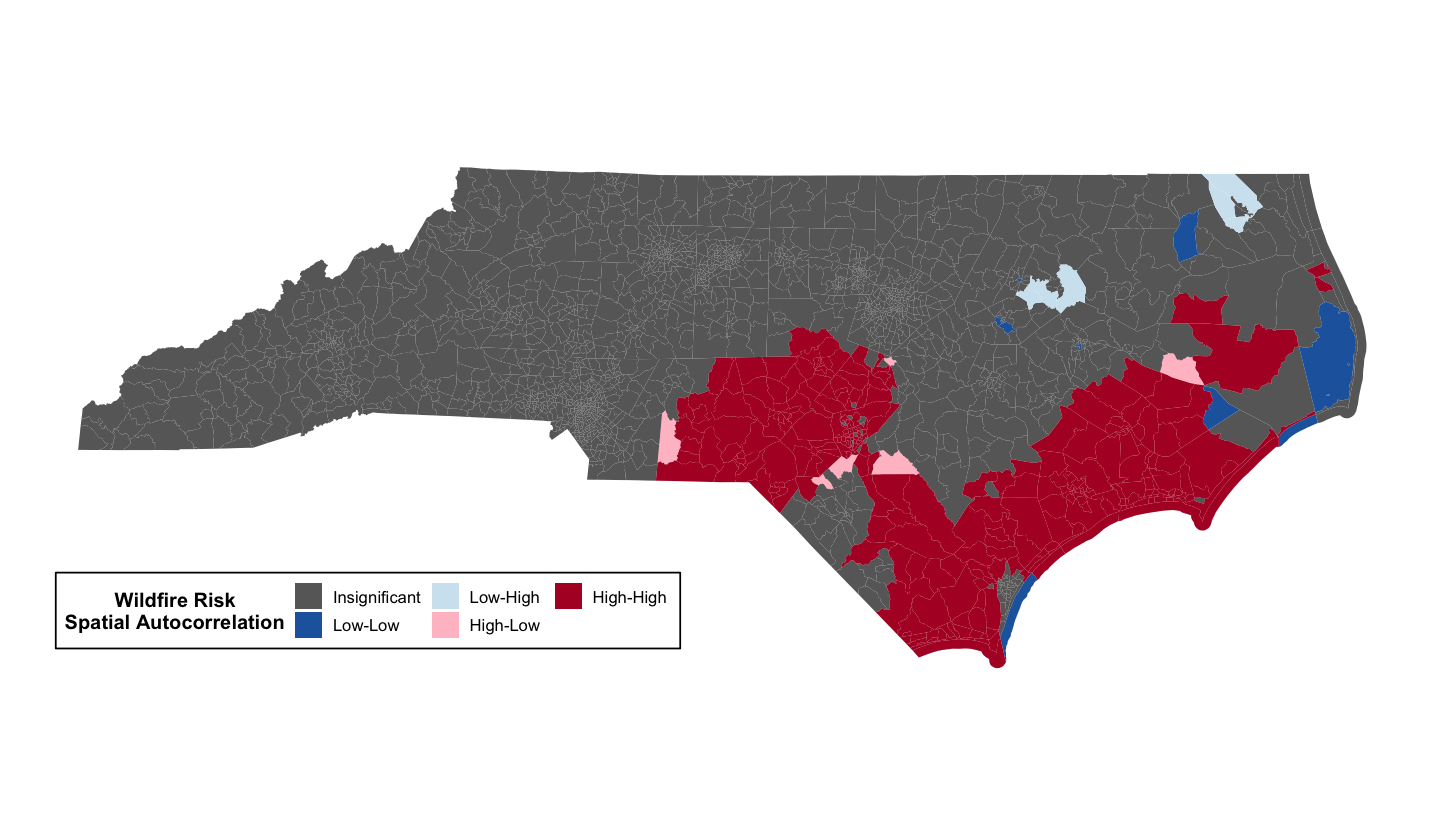

In [17]:
ggplot(whp_spatial_sf) +
  geom_sf(aes(fill = quadrant_intervals, geometry = geometry), 
          color = NA) + 

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_manual(values = quadrant_colors, 
                    labels = c("Insignificant", "Low-Low", "Low-High", "High-Low", "High-High"),
      name = "         Wildfire Risk\nSpatial Autocorrelation") + 

  guides(fill = guide_legend(nrow = 2)) # adding rows to legend